In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd

In [2]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [3]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [4]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [5]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [6]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [7]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [8]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


<Axes: >

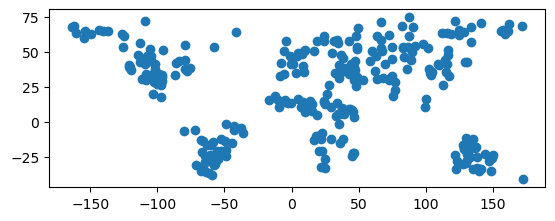

In [9]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))
df_sites.plot()

In [10]:
df_sites.to_file('dist_hls_val.geojson', driver='GeoJSON')